# dfGP

- write the functions that matter

In [56]:
from GP_models import GP_predict, optimise_hypers_on_train
from simulate import simulate_convergence, simulate_branching, simulate_ridge, simulate_merge, simulate_deflection
from metrics import compute_RMSE, compute_MAE, log_likelihood_test
from utils import set_seed
from metrics import compute_RMSE

# Global file for training configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, GP_LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE, N_SIDE, DFGP_RESULTS_DIR, SIGMA_F_RANGE, L_RANGE

import torch
from torch.func import vmap, jacfwd
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import os
import pandas as pd

# Set seed for reproducibility
set_seed(42)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

model_name = "dfGP"

#########################
### x_train & y_train ###
#########################

# Import all simulation functions
from simulate import (
    simulate_convergence,
    simulate_branching,
    simulate_merge,
    simulate_deflection,
    simulate_ridge,
)

# Define simulations as a dictionary with names as keys to function objects
simulations = {
    "convergence": simulate_convergence,
    "branching": simulate_branching,
    "merge": simulate_merge,
    "deflection": simulate_deflection,
    "ridge": simulate_ridge,
}

# Load training inputs
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Storage dictionaries
y_train_dict = {}

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate training observations
    y_train = sim_func(x_train)
    y_train_dict[sim_name] = y_train  # Store training outputs

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print()

#######################
### x_test & y_test ###
#######################

print("=== Generating test data ===")

# Choose discretisation that is good for simulations and also for quiver plotting
N_SIDE = N_SIDE

side_array = torch.linspace(start = 0.0, end = 1.0, steps = N_SIDE)
XX, YY = torch.meshgrid(side_array, side_array, indexing = "xy")
x_test_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim = -1)
# long format
x_test = x_test_grid.reshape(-1, 2)

# Storage dictionaries
y_test_dict = {}

# Make y_test_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate test observations
    y_test = sim_func(x_test)
    y_test_dict[sim_name] = y_test  # Store test outputs

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print()

    # visualise_v_quiver(y_test, x_test, title_string = name)

#####################
### Training loop ###
#####################

# Early stopping parameters
PATIENCE = PATIENCE
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
MAX_NUM_EPOCHS = 100

# Number of training runs for mean and std of metrics
NUM_RUNS = NUM_RUNS
NUM_RUNS = 2
LEARNING_RATE = GP_LEARNING_RATE
WEIGHT_DECAY = WEIGHT_DECAY

# Pass in all the training data
# BATCH_SIZE = BATCH_SIZE

# Ensure the results folder exists
RESULTS_DIR = DFGP_RESULTS_DIR
os.makedirs(RESULTS_DIR, exist_ok = True)

### LOOP OVER SIMULATIONS ###
for sim_name, sim_func in simulations.items():
    print(f"\nTraining for {sim_name.upper()}...")

    # Store metrics for the current simulation
    simulation_results = []

    # x_train is the same, select y_train
    x_train = x_train.to(device)

    y_train = y_train_dict[sim_name].to(device)
    # select the correct y_test (PREVIOUS ERROR)
    y_test = y_test_dict[sim_name].to(device)

    ### LOOP OVER RUNS ###
    for run in range(NUM_RUNS):
        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # Sample from uniform distributions to initialise hyperparameters
        sigma_n = torch.tensor([0.05], requires_grad = False).to(device) # no optimisation for noise, no sampling
        sigma_f = torch.tensor([torch.empty(1).uniform_(* SIGMA_F_RANGE)], requires_grad = True) # Trainable
        l = torch.tensor(torch.empty(2).uniform_(* L_RANGE), requires_grad = True) # Trainable

        learnable_hyperparameters_init = [sigma_f, l]
        learnable_hyperparameters = [param.detach().clone().to(device).requires_grad_() for param in learnable_hyperparameters_init]

        all_hyperparameters = [sigma_n] + learnable_hyperparameters
        
        # We do not need to "initialse" the GP model
        # We don't need a criterion either

        # Define optimizer (e.g., AdamW)
        optimizer = optim.AdamW([sigma_f, l], lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

        # Initialise tensors to store losses for this run
        epoch_train_losses = torch.zeros(MAX_NUM_EPOCHS)
        epoch_train_RMSE_losses = torch.zeros(MAX_NUM_EPOCHS)
        epoch_test_RMSE_losses = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        epochs_no_improve = 0

        # Convert to DataLoader for batching
        dataset = TensorDataset(x_train, y_train)
        # Pass in full training dataset as batch!!
        dataloader = DataLoader(dataset, batch_size = x_train.shape[0], shuffle = True)

        ### LOOP OVER EPOCHS ###
        print("\nStart Training")
        for epoch in range(MAX_NUM_EPOCHS):

            epoch_train_loss = 0.0  # Accumulate batch losses within epoch
            epoch_test_loss = 0.0

            for batch in dataloader:

                x_batch, y_batch = batch
                # put on GPU
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                x_batch.requires_grad_()

                # THIS DOES NOT WORK
                mean_pred_train, _, lml_batch = GP_predict(
                     x_batch,
                     y_batch,
                     x_batch, # have predictions for training data again
                     [sigma_n, sigma_f, l], # initial hyperparameters
                     # no mean
                     divergence_free_bool = True)

                # - lml because loss in minimised
                loss = - lml_batch
                epoch_train_loss += loss.item()

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            ### END BATCH LOOP ###
            # Compute test loss for loss convergence plot
            mean_pred_test, _, _ = GP_predict(
                     x_train,
                     y_train,
                     x_test.to(device), # have predictions for training data again
                     all_hyperparameters, # initial hyperparameters
                     # no mean
                     divergence_free_bool = True)
            
            test_loss_RMSE = compute_RMSE(y_test, mean_pred_test)
            
            # Compute average loss for the epoch (e.g. #batches/epoch)
            avg_train_loss = epoch_train_loss / len(dataloader)

            epoch_train_losses[epoch] = avg_train_loss
            epoch_train_RMSE_losses[epoch] = compute_RMSE(y_train, mean_pred_train)
            # epoch_test_RMSE_losses[epoch] = test_loss_RMSE

            print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {avg_train_loss:.4f}, (RMSE): {epoch_train_RMSE_losses[epoch]:.4f}")

            # Early stopping check
            if avg_train_loss < best_loss:
                best_loss = avg_train_loss
                epochs_no_improve = 0  # Reset counter
                # best_model_state = dfNN_model.state_dict()  # Save best model
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        ################
        ### EVALUATE ###
        ################

        # Evaluate the trained model after all epochs are finished/early stopping

        mean_pred_test, covar_pred_test, _ = GP_predict(
                     x_train,
                     y_train,
                     x_test.to(device),
                     [sigma_n, sigma_f, l], # optimal hypers
                     # no mean
                     divergence_free_bool = True)

        # Only save things for one run
        if run == 0:
            #(1) Save predictions from first run so we can visualise them later
            torch.save(mean_pred_test, f"{RESULTS_DIR}/{sim_name}_{model_name}_test_mean_predictions.pt")
            torch.save(covar_pred_test, f"{RESULTS_DIR}/{sim_name}_{model_name}_test_covar_predictions.pt")

            #(2) Save loss over epochs
            df_losses = pd.DataFrame({
                'Epoch': list(range(epoch_train_losses.shape[0])), # pythonic
                'Train Loss RMSE': epoch_train_losses.tolist(), 
                'Test Loss RMSE': epoch_test_RMSE_losses.tolist()
                })
            
            df_losses.to_csv(f"{RESULTS_DIR}/{sim_name}_{model_name}_losses_over_epochs.csv", index = False)

        # Compute Divergence (convert tensor to float)
        # dfNN_train_div = torch.diagonal(vmap(jacfwd(dfNN_model))(x_train.to(device)), dim1 = -2, dim2 = -1).detach().sum().item()
        # dfNN_test_div = torch.diagonal(vmap(jacfwd(dfNN_model))(x_test.to(device)), dim1 = -2, dim2 = -1).detach().sum().item()

        # Compute metrics (convert tensors to float)
        dfNN_test_RMSE = compute_RMSE(y_test, mean_pred_test).item()
        dfNN_test_MAE = compute_MAE(y_test, mean_pred_test).item()
        dfNN_test_NLL = - log_likelihood_test(mean_pred_test, covar_pred_test, y_test).item()

        # dfNN_test_RMSE = compute_RMSE(y_test, y_test_dfNN_predicted.cpu()).item()
        # dfNN_test_MAE = compute_MAE(y_test, y_test_dfNN_predicted.cpu()).item()

        # BEST HYPERS 
        best_hypers = {
            "sigma_n": sigma_n.detach().cpu(),
            "sigma_f": sigma_f.detach().cpu(),
            "l": l.detach().cpu(),
        }

        simulation_results.append([
            run + 1, dfNN_test_RMSE, dfNN_test_MAE, dfNN_test_NLL
        ])

    ### FINISH LOOP OVER RUNS ###
    # Convert results to a Pandas DataFrame
    df = pd.DataFrame(
        simulation_results, 
        columns = ["Run", "Test RMSE", "Test MAE", "Test NLL"])

    # Compute mean and standard deviation for each metric
    mean_std_df = df.iloc[:, 1:].agg(["mean", "std"])  # Exclude "Run" column

    # Save results to CSV
    results_file = os.path.join(RESULTS_DIR, f"{sim_name}_{model_name}_metrics_per_run.csv")
    df.to_csv(results_file, index = False)
    print(f"\nResults saved to {results_file}")

    # Save mean and standard deviation to CSV
    mean_std_file = os.path.join(RESULTS_DIR, f"{sim_name}_{model_name}_metrics_summary.csv")
    mean_std_df.to_csv(mean_std_file)
    print(f"\nMean & Std saved to {mean_std_file}")
    # Only train for one simulation for now

Using device: cuda

=== CONVERGENCE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== BRANCHING ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== MERGE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== DEFLECTION ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== RIDGE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== Generating test data ===
=== CONVERGENCE ===
Test inputs shape: torch.Size([400, 2])
Test observations shape: torch.Size([400, 2])
Test inputs dtype: torch.float32

=== BRANCHING ===
Test inputs shape: torch.Size([400, 2])
Test obs

/tmp/ipykernel_1258364/2015821307.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l = torch.tensor(torch.empty(2).uniform_(* L_RANGE), requires_grad = True) # Trainable


convergence dfGP Run 1/2, Epoch 9/100, Training Loss (NLML): -906.2213, (RMSE): 0.4311
convergence dfGP Run 1/2, Epoch 10/100, Training Loss (NLML): -907.6769, (RMSE): 0.4253
convergence dfGP Run 1/2, Epoch 11/100, Training Loss (NLML): -909.1094, (RMSE): 0.4254
convergence dfGP Run 1/2, Epoch 12/100, Training Loss (NLML): -910.4360, (RMSE): 0.4319
convergence dfGP Run 1/2, Epoch 13/100, Training Loss (NLML): -911.7875, (RMSE): 0.4069
convergence dfGP Run 1/2, Epoch 14/100, Training Loss (NLML): -913.0176, (RMSE): 0.4256
convergence dfGP Run 1/2, Epoch 15/100, Training Loss (NLML): -914.2368, (RMSE): 0.4242
convergence dfGP Run 1/2, Epoch 16/100, Training Loss (NLML): -915.4384, (RMSE): 0.4166
convergence dfGP Run 1/2, Epoch 17/100, Training Loss (NLML): -916.5403, (RMSE): 0.4142
convergence dfGP Run 1/2, Epoch 18/100, Training Loss (NLML): -917.6466, (RMSE): 0.4270
convergence dfGP Run 1/2, Epoch 19/100, Training Loss (NLML): -918.6494, (RMSE): 0.4228
convergence dfGP Run 1/2, Epoch 2

In [55]:
df

,Run,Test RMSE,Test MAE,Test NLL
0,1,0.006257,0.003661,-2900.965088
1,2,0.005001,0.002733,-2838.842285


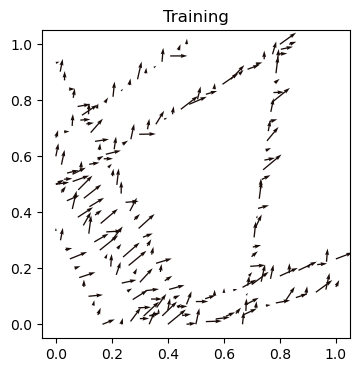

In [47]:
# torch.sqrt(torch.mean(torch.square(mean_pred_train - y_train)))
torch.sqrt(torch.mean(torch.square(mean_pred_test - y_test)))

visualise_v_quiver(mean_pred_train.cpu().detach(), x_train.cpu(), title_string = "Training")

In [49]:
learnable_hyperparameters

[tensor([1.9411], device='cuda:0', requires_grad=True),
 tensor([0.7575, 0.4914], device='cuda:0', requires_grad=True)]

In [ ]:
from GP_models import predict_GP, optimise_hypers_on_train
from simulate import simulate_convergence, simulate_branching, simulate_ridge, simulate_merge, simulate_deflection
from metrics import compute_RMSE, compute_MAE
from utils import set_seed

# Global file for training configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE, N_SIDE, DFGP_RESULTS_DIR, SIGMA_F_RANGE, L_RANGE

import torch
from torch.func import vmap, jacfwd
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import os
import pandas as pd

# Set seed for reproducibility
set_seed(42)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

model_name = "dfNN"

#########################
### x_train & y_train ###
#########################

# Import all simulation functions
from simulate import (
    simulate_convergence,
    simulate_branching,
    simulate_merge,
    simulate_deflection,
    simulate_ridge,
)

# Define simulations as a dictionary with names as keys to function objects
simulations = {
    "convergence": simulate_convergence,
    "branching": simulate_branching,
    "merge": simulate_merge,
    "deflection": simulate_deflection,
    "ridge": simulate_ridge,
}

# Load training inputs
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt").float()

# Storage dictionaries
y_train_dict = {}

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate training observations
    y_train = sim_func(x_train)
    y_train_dict[sim_name] = y_train  # Store training outputs

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print()

#######################
### x_test & y_test ###
#######################

print("=== Generating test data ===")

# Choose discretisation that is good for simulations and also for quiver plotting
N_SIDE = N_SIDE

side_array = torch.linspace(start = 0.0, end = 1.0, steps = N_SIDE)
XX, YY = torch.meshgrid(side_array, side_array, indexing = "xy")
x_test_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim = -1)
# long format
x_test = x_test_grid.reshape(-1, 2)

# Storage dictionaries
y_test_dict = {}

# Make y_test_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate test observations
    y_test = sim_func(x_test)
    y_test_dict[sim_name] = y_test  # Store test outputs

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print()

    # visualise_v_quiver(y_test, x_test, title_string = name)

#####################
### Training loop ###
#####################

# Early stopping parameters
PATIENCE = PATIENCE
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS

# Number of training runs for mean and std of metrics
NUM_RUNS = NUM_RUNS
LEARNING_RATE = LEARNING_RATE
WEIGHT_DECAY = WEIGHT_DECAY

# Pass in all the training data
# BATCH_SIZE = BATCH_SIZE

# Ensure the results folder exists
RESULTS_DIR = DFGP_RESULTS_DIR
os.makedirs(RESULTS_DIR, exist_ok = True)

### LOOP OVER SIMULATIONS ###
for sim_name, sim_func in simulations.items():
    print(f"\nTraining for {sim_name.upper()}...")

    # Store metrics for the current simulation
    simulation_results = []

    # x_train is the same, select y_train
    y_train = y_train_dict[sim_name]
    # select the correct y_test (PREVIOUS ERROR)
    y_test = y_test_dict[sim_name]

    ### LOOP OVER RUNS ###
    for run in range(NUM_RUNS):
        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # Sample from uniform distributions
        sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise, no sampling
        sigma_f = torch.tensor([torch.empty(1).uniform_(* SIGMA_F_RANGE)], requires_grad = True)   # Trainable
        l = torch.tensor(torch.empty(2).uniform_(* L_RANGE), requires_grad = True)  # Trainable

        print(f"sigma_n: {sigma_n.item():.4f}, sigma_f: {sigma_f.item():.4f}, l: {l[0].item():.4f}, {l[1].item():.4f}")

        # Convert to DataLoader for batching
        dataset = TensorDataset(x_train, y_train)
        # Pass in full training dataset as batch
        dataloader = DataLoader(dataset, batch_size = x_train.shape[0], shuffle = True)

        # Initialise fresh model
        # we seeded so this is reproducible
        dfNN_model = dfNN_for_vmap().to(device)

        # Define loss function (e.g., MSE for regression)
        criterion = torch.nn.MSELoss()

        # Define optimizer (e.g., AdamW)
        optimizer = optim.AdamW(dfNN_model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

        # Initialise tensors to store losses for this run
        epoch_train_losses = torch.zeros(MAX_NUM_EPOCHS)
        epoch_test_losses = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        epochs_no_improve = 0

        ### LOOP OVER EPOCHS ###
        print("\nStart Training")
        for epoch in range(MAX_NUM_EPOCHS):

            epoch_train_loss = 0.0  # Accumulate batch losses within epoch
            epoch_test_loss = 0.0

            for batch in dataloader:
                # assure model is in training mode 
                dfNN_model.train()

                x_batch, y_batch = batch
                # put on GPU
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                x_batch.requires_grad_()

                # Forward pass
                y_pred = vmap(dfNN_model)(x_batch)

                # Compute loss (RMSE for same units as data) - criterion(pred, target)
                loss = torch.sqrt(criterion(y_pred, y_batch))
                epoch_train_loss += loss.item()

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            ### END BATCH LOOP ###
            dfNN_model.eval()
            # Compute test loss for loss convergence plot
            y_test_pred = vmap(dfNN_model)(x_test.to(device))
            test_loss = torch.sqrt(criterion(y_test_pred, y_test.to(device))).item()
            
            # Compute average loss for the epoch (e.g. 7 batches/epoch)
            avg_train_loss = epoch_train_loss / len(dataloader)

            epoch_train_losses[epoch] = avg_train_loss
            epoch_test_losses[epoch] = test_loss

            print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (RMSE): {avg_train_loss:.4f}")

            # debug
            # Early stopping check
            if avg_train_loss < best_loss:
                best_loss = avg_train_loss
                epochs_no_improve = 0  # Reset counter
                best_model_state = dfNN_model.state_dict()  # Save best model
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break
        
        ### END EPOCH LOOP ###
        # Load the best model before stopping for this "run"
        dfNN_model.load_state_dict(best_model_state)
        print(f"Run {run + 1}/{NUM_RUNS}, Training of {model_name} complete for {sim_name.upper()}. Restored best model.")

        ################
        ### EVALUATE ###
        ################

        # Evaluate the trained model after epochs are finished
        dfNN_model.eval()

        y_train_dfNN_predicted = vmap(dfNN_model)(x_train.to(device)).detach()
        y_test_dfNN_predicted = vmap(dfNN_model)(x_test.to(device)).detach()

        # Only save things for one run
        if run == 0:
            #(1) Save predictions from first run so we can visualise them later
            torch.save(y_test_dfNN_predicted, f"{RESULTS_DIR}/{sim_name}_{model_name}_test_predictions.pt")

            #(2) Save loss over epochs
            df_losses = pd.DataFrame({
                'Epoch': list(range(epoch_train_losses.shape[0])), # pythonic
                'Train Loss RMSE': epoch_train_losses.tolist(), 
                'Test Loss RMSE': epoch_test_losses.tolist()
                })
            
            df_losses.to_csv(f"{RESULTS_DIR}/{sim_name}_{model_name}_losses_over_epochs.csv", index = False)

        # Compute Divergence (convert tensor to float)
        dfNN_train_div = torch.diagonal(vmap(jacfwd(dfNN_model))(x_train.to(device)), dim1 = -2, dim2 = -1).detach().sum().item()
        dfNN_test_div = torch.diagonal(vmap(jacfwd(dfNN_model))(x_test.to(device)), dim1 = -2, dim2 = -1).detach().sum().item()

        # Compute metrics (convert tensors to float)
        dfNN_train_RMSE = compute_RMSE(y_train, y_train_dfNN_predicted.cpu()).item()
        dfNN_train_MAE = compute_MAE(y_train, y_train_dfNN_predicted.cpu()).item()

        dfNN_test_RMSE = compute_RMSE(y_test, y_test_dfNN_predicted.cpu()).item()
        dfNN_test_MAE = compute_MAE(y_test, y_test_dfNN_predicted.cpu()).item()

        # Store results in list
        simulation_results.append([
            run + 1, dfNN_train_RMSE, dfNN_train_MAE, dfNN_train_div,
            dfNN_test_RMSE, dfNN_test_MAE, dfNN_test_div
        ])

    ### FINISH LOOP OVER RUNS ###
    # Convert results to a Pandas DataFrame
    df = pd.DataFrame(
        simulation_results, 
        columns = ["Run", "Train RMSE", "Train MAE", "Train Divergence",
                   "Test RMSE", "Test MAE", "Test Divergence"])

    # Compute mean and standard deviation for each metric
    mean_std_df = df.iloc[:, 1:].agg(["mean", "std"])  # Exclude "Run" column

    # Save results to CSV
    results_file = os.path.join(RESULTS_DIR, f"{sim_name}_{model_name}_metrics_per_run.csv")
    df.to_csv(results_file, index = False)
    print(f"\nResults saved to {results_file}")

    # Save mean and standard deviation to CSV
    mean_std_file = os.path.join(RESULTS_DIR, f"{sim_name}_{model_name}_metrics_summary.csv")
    mean_std_df.to_csv(mean_std_file)
    print(f"\nMean & Std saved to {mean_std_file}")
    # Only train for one simulation for now